In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import time

# Define dataset paths
data_dir = "C:\\Users\\HP\\Documents\\major_project\\Data_set\\final_datasets\\final_datasetsssss"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "validation")

# Data Augmentation for Training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Standard Transform for Test/Validation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features

# Modify the classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader, criterion)

        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1}: Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f} sec')
    
    total_time = time.time() - start_time
    print(f'\nTotal Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)')
    torch.save(model.state_dict(), "best_mobilenetv2_model.pth")  # Save the final model
    return model

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    total_time = time.time() - start_time
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"Evaluation Time: {total_time:.2f} seconds")
    return accuracy, avg_loss

# Measure inference time
def measure_inference_time(model, data_loader, num_batches=10):
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)
    
    total_time = time.time() - start_time
    avg_time_per_batch = total_time / num_batches
    print(f"Average Inference Time per Batch: {avg_time_per_batch:.4f} seconds")

# Train and evaluate
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)
model.load_state_dict(torch.load("best_mobilenetv2_model.pth"))  # Load final model
test_accuracy, _ = evaluate_model(model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Measure inference time
measure_inference_time(model, test_loader)


C:\Users\HP\anaconda3\python\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Evaluation Time: 25.23 seconds
Epoch 1: Loss: 0.4230, Train Acc: 81.18%, Val Acc: 92.79%, Time: 670.39 sec
Evaluation Time: 18.89 seconds
Epoch 2: Loss: 0.2088, Train Acc: 92.36%, Val Acc: 94.26%, Time: 565.41 sec
Evaluation Time: 18.89 seconds
Epoch 3: Loss: 0.1709, Train Acc: 93.37%, Val Acc: 97.70%, Time: 558.64 sec
Evaluation Time: 18.80 seconds
Epoch 4: Loss: 0.1400, Train Acc: 94.94%, Val Acc: 98.20%, Time: 560.19 sec
Evaluation Time: 18.81 seconds
Epoch 5: Loss: 0.1368, Train Acc: 94.64%, Val Acc: 98.03%, Time: 557.96 sec
Evaluation Time: 18.67 seconds
Epoch 6: Loss: 0.1284, Train Acc: 95.31%, Val Acc: 98.20%, Time: 554.85 sec
Evaluation Time: 18.73 seconds
Epoch 7: Loss: 0.1211, Train Acc: 95.54%, Val Acc: 98.20%, Time: 557.96 sec
Evaluation Time: 18.92 seconds
Epoch 8: Loss: 0.1160, Train Acc: 95.70%, Val Acc: 98.03%, Time: 558.70 sec
Evaluation Time: 19.03 seconds
Epoch 9: Loss: 0.1125, Train Acc: 96.05%, Val Acc: 98.20%, Time: 552.95 sec
Evaluation Time: 18.89 seconds
Epoch 

<ipython-input-1-2da46e31c12d>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mobilenetv2_model.pth"))  # Load final model


Evaluation Time: 25.37 seconds
Test Accuracy: 97.55%
Average Inference Time per Batch: 0.9940 seconds


Precision: 0.9757
Recall: 0.9755
F1-Score: 0.9756

Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.96      0.96       212
   malignant       1.00      1.00      1.00       257
      normal       0.94      0.96      0.95       144

    accuracy                           0.98       613
   macro avg       0.97      0.97      0.97       613
weighted avg       0.98      0.98      0.98       613



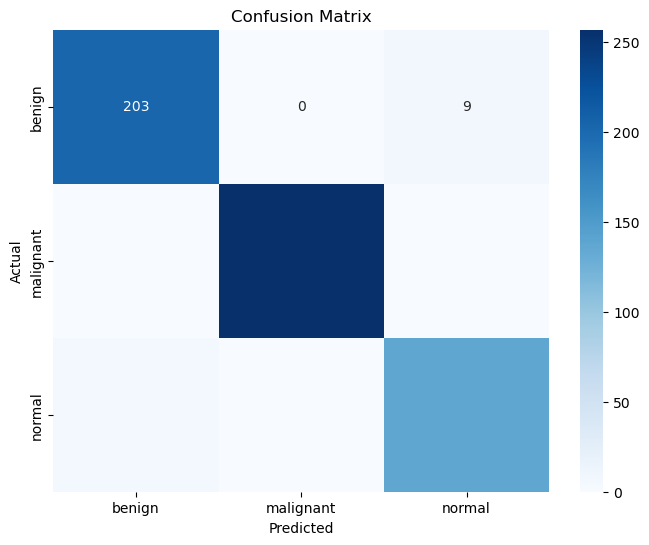

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_metrics(model, data_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute Precision, Recall, and F1-Score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names from dataset
class_names = train_dataset.classes  # Assuming class names are the same across datasets

# Evaluate model
evaluate_metrics(model, test_loader, class_names)


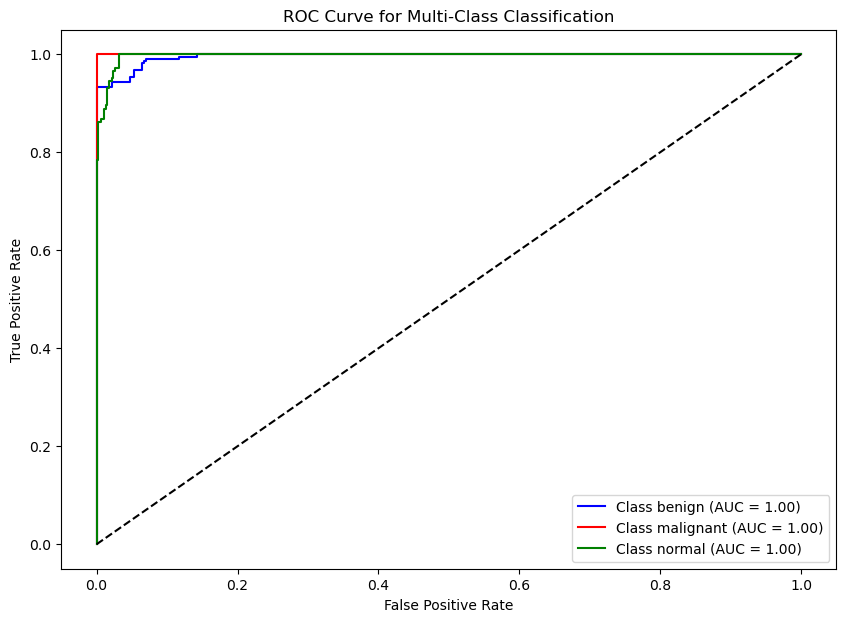

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_auc(model, data_loader, num_classes, class_names):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Raw scores before softmax
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize the labels for multi-class ROC computation
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    # Compute ROC curve and AUC for each class
    plt.figure(figsize=(10, 7))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta']

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

    # Plot random chance line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc='lower right')
    plt.show()

# Get class names from dataset
class_names = train_dataset.classes  
num_classes = len(class_names)

# Call function to plot ROC curves
plot_roc_auc(model, test_loader, num_classes, class_names)


In [4]:
import torch
from torchvision import transforms, models
from PIL import Image

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained MobileNetV2 model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features

# Modify the classifier to match training
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 3)  # 3 classes: Benign, Malignant, Normal
)

# Load trained weights
model.load_state_dict(torch.load("best_mobilenetv2_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to the image
image_path = r"C:\Users\HP\Documents\major_project\Data_set\final_datasets\final_datasetsssss\test\benign\image_635.png"

# Open the image
image = Image.open(image_path).convert("RGB")

# Apply transformations
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

# Define class names
class_names = ["Benign", "Malignant", "Normal"]

# Get predicted class
predicted_class = class_names[predicted.item()]
print(f"Predicted Class: {predicted_class}")


Predicted Class: Benign


<ipython-input-4-bb4a7a0abe06>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mobilenetv2_model.pth", map_location=device))


In [ ]:
!pip install streamlit


In [ ]:
!pip install torch torchvision pandas matplotlib seaborn


In [ ]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained MobileNetV2 model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features

# Modify the classifier to match training
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 3)  # 3 classes: Benign, Malignant, Normal
)

# Load trained weights
model.load_state_dict(torch.load("best_mobilenetv2_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define class names
class_names = ["Benign", "Malignant", "Normal"]

# Streamlit app
st.title("Lung Cancer Classification with MobileNetV2")
st.write("Upload a CT scan image to classify it into one of the following categories: Benign, Malignant, or Normal.")

# File uploader
uploaded_file = st.file_uploader("Choose a CT scan image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Open and display the image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    input_image = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()
        predicted_class = class_names[np.argmax(probabilities)]

    # Display results
    st.subheader("Prediction")
    st.write(f"**Predicted Class:** {predicted_class}")

    # Display confidence scores
    st.subheader("Confidence Scores")
    for i, class_name in enumerate(class_names):
        st.write(f"{class_name}: {probabilities[i] * 100:.2f}%")

    # Plot confidence scores
    fig, ax = plt.subplots()
    ax.bar(class_names, probabilities * 100, color=['blue', 'red', 'green'])
    ax.set_ylabel("Confidence (%)")
    ax.set_title("Confidence Scores for Each Class")
    st.pyplot(fig)

# Footer
st.markdown("---")
st.write("Developed with Streamlit and PyTorch")

""")


In [ ]:
!streamlit run app.py


In [1]:
# Step 1: Write the Streamlit app code to a Python file
streamlit_code = """
import streamlit as st
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained MobileNetV2 model
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features

# Modify the classifier to match training
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 3)  # 3 classes: Benign, Malignant, Normal
)

# Load trained weights
model.load_state_dict(torch.load("best_mobilenetv2_model.pth", map_location=device))
model.to(device)
model.eval()

# Define transformation for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define class names
class_names = ["Benign", "Malignant", "Normal"]

# Streamlit app
st.title("Lung Cancer Classification with MobileNetV2")
st.write("Upload a CT scan image to classify it into one of the following categories: Benign, Malignant, or Normal.")

# File uploader
uploaded_file = st.file_uploader("Choose a CT scan image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Open and display the image
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess the image
    input_image = transform(image).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_image)
        probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu().numpy()
        predicted_class = class_names[np.argmax(probabilities)]

    # Display results
    st.subheader("Prediction")
    st.write(f"**Predicted Class:** {predicted_class}")

    # Display confidence scores
    st.subheader("Confidence Scores")
    for i, class_name in enumerate(class_names):
        st.write(f"{class_name}: {probabilities[i] * 100:.2f}%")

    # Plot confidence scores
    fig, ax = plt.subplots()
    ax.bar(class_names, probabilities * 100, color=['blue', 'red', 'green'])
    ax.set_ylabel("Confidence (%)")
    ax.set_title("Confidence Scores for Each Class")
    st.pyplot(fig)

# Footer
st.markdown("---")
st.write("Developed with Streamlit and PyTorch")
"""

# Write the code to a file named 'app.py'
with open("app.py", "w") as file:
    file.write(streamlit_code)

print("Streamlit app code saved to 'app.py'")


Streamlit app code saved to 'app.py'


In [2]:
# Step 2: Run the Streamlit app from Jupyter Notebook
!streamlit run app.py


Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\python\Scripts\streamlit-script.py", line 6, in <module>
    from streamlit.cli import main
ModuleNotFoundError: No module named 'streamlit.cli'


In [3]:
!pip install streamlit

In [ ]:
!pip install streamlit.cli